# Capsule Networks (CapsNets)

Based on the [work done by Aurélien Géron](https://github.com/ageron/handson-ml) [and Luke Bieri](https://github.com/lukebieri/capsnet).                                             
Which is based on the paper: [Dynamic Routing Between Capsules](https://arxiv.org/abs/1710.09829), by Sara Sabour, Nicholas Frosst and Geoffrey E. Hinton (NIPS 2017). And inspired in part from Huadong Liao's implementation: [CapsNet-TensorFlow](https://github.com/naturomics/CapsNet-Tensorflow).

# Imports

In [1]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

import os, cv2, sys

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

print("Libraries imported...")

Using Theano backend.


Libraries imported...


Set seeds to always produces the same output:

In [2]:
#np.random.seed(42)
#tf.compat.v1.set_random_seed(42)

# Load the dataset

In [3]:
data_path = ("C:\\Users\\Matt\\Documents\\Mushrooms" + "\\Data")
data_dir_list = os.listdir(data_path)

img_rows=256
img_cols=256
num_channel=1

splitpropor=0.7

num_classes = 9
num_imgs_per_classes = 300

target=[]
imgId = 0
img_data_list=[]


img_list=os.listdir(data_path) #'C:/Users/Matt/Documents/Cours/AI/Mushrooms/Agaricus/'+ dataset
print ('Loaded the images of dataset-'+'{}\n'.format(data_path))
print(img_list,"\n")

for folder in img_list:
    
    print ('Opening folder '+'{}'.format(data_path)+ "\\"+ folder)
    openedFolder = os.listdir(data_path + "\\" + folder)
    nbimg=0
    
    for img in openedFolder:
        
        input_img=cv2.imread(data_path + "\\" + folder + '\\' + img )
        
        if (num_channel==1):
            input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
            
        input_img_resize=cv2.resize(input_img,(img_rows,img_cols))
        
        img_data_list.append(input_img_resize)
        target.append(imgId)
        
        nbimg+=1
        if (nbimg>=num_imgs_per_classes):
            break
            
    imgId+=1


img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data /= 255


target = np.array(target)
target = np_utils.to_categorical(target, 9)
target.reshape(target.shape[0],target.shape[1],1)
print("done...")

Loaded the images of dataset-C:\Users\Matt\Documents\Mushrooms\Data

['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus'] 

Opening folder C:\Users\Matt\Documents\Mushrooms\Data\Agaricus
Opening folder C:\Users\Matt\Documents\Mushrooms\Data\Amanita
Opening folder C:\Users\Matt\Documents\Mushrooms\Data\Boletus
Opening folder C:\Users\Matt\Documents\Mushrooms\Data\Cortinarius
Opening folder C:\Users\Matt\Documents\Mushrooms\Data\Entoloma
Opening folder C:\Users\Matt\Documents\Mushrooms\Data\Hygrocybe
Opening folder C:\Users\Matt\Documents\Mushrooms\Data\Lactarius
Opening folder C:\Users\Matt\Documents\Mushrooms\Data\Russula
Opening folder C:\Users\Matt\Documents\Mushrooms\Data\Suillus
done...


We verify that the dataset is what we want

2700  images
(2700, 256, 256, 1)


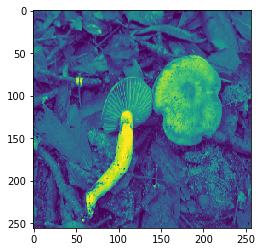

In [4]:
nbOfImgs = img_data.shape[0]

plt.imshow(img_data[np.random.randint(0, nbOfImgs)])
print(nbOfImgs, " images")

img_data = img_data.reshape(img_data.shape[0], img_data.shape[1], img_data.shape[2], 1)
print(img_data.shape)

splitRank=nbOfImgs*splitpropor
splitRank=int(splitRank)

We save the data in a buffer.

In [5]:
meh = np.array(img_data)
meeh = np.array(target)

So we can restore them easily if needed.

In [6]:
img_data = np.array(meh)
target = np.array(meeh)

Shuffling the dataset.

In [7]:
print(img_data.shape, " / ", target.shape)
randShuffle = np.arange(target.shape[0])
np.random.shuffle(randShuffle)

img_data = img_data[randShuffle]
target = target[randShuffle]
print("\nInput data shuffled !\n")

(2700, 256, 256, 1)  /  (2700, 9)

Input data shuffled !



Splitting the dataset.

In [8]:
(X_train, Y_train), (X_test, Y_test) = (img_data[:splitRank], target[:splitRank]), (img_data[splitRank:], target[splitRank:])
print(X_train.shape, " + ", X_test.shape, " = ", X_train.shape[0]+X_test.shape[0])

(1889, 256, 256, 1)  +  (811, 256, 256, 1)  =  2700


# Digit Capsules

We need a way to compute the norm of a vector safely (avoid the nan when differentiating by 0).

In [9]:
def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False):
    
    squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keepdims=keep_dims)
    
    return tf.sqrt(squared_norm + epsilon)

Squash function, based on the paper (same purpose as tanh but better) :

$\operatorname{squash}(\mathbf{s}) = \dfrac{\|\mathbf{s}\|^2}{1 + \|\mathbf{s}\|^2} \dfrac{\mathbf{s}}{\|\mathbf{s}\|}$

In [10]:
def squash(s, axis=-1):    
    
    safeNorm = safe_norm(s, axis=axis, keep_dims=True)
    squared_norm = tf.square(safeNorm)
    
    squash_factor = squared_norm / (1. + squared_norm)
    unit_vector = s / safeNorm
    
    squashed_output = tf.multiply(squash_factor, unit_vector)
    
    return squashed_output

Let's write our own keras layer based on [the keras documentation](https://keras.io/layers/writing-your-own-keras-layers/)

In [11]:
class CapsuleLayer(tf.keras.layers.Layer):

    def __init__(self, num_capsule_output, dim_vector, num_routing=3, **kwargs):
        
        super(CapsuleLayer, self).__init__(**kwargs)
        
        self.num_capsule = num_capsule_output
        self.dim_vector = dim_vector
        assert num_routing > 0, 'The num_routing should be > 0'
        self.num_routing = num_routing

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_vector]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.input_num_capsule, self.num_capsule, self.dim_vector, self.input_dim_vector],
                                 initializer='glorot_uniform', name='W', trainable=True)  # tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.5)

        # Coupling coefficient. The redundant dimensions are just to facilitate subsequent matrix calculation.
        self.bias = self.add_weight(shape=[self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer='zeros',
                                    name='bias',
                                    trainable=False)
        
        super(CapsuleLayer, self).build(input_shape)

    def call(self, inputs): #inputs = caps1 output
        
        inputs_expanded = tf.expand_dims(inputs, -1)
        inputs_tile = tf.expand_dims(inputs_expanded, 2)

        inputs_tiled = tf.tile(inputs_tile, [1, 1, self.num_capsule, 1, 1])
        
        caps2_predicted = tf.matmul(tf.expand_dims(self.W, 0), inputs_tiled)
        
        raw_weights = tf.expand_dims(self.bias, 0)
        
        
        for i in range(self.num_routing - 1):
            routing_weights = tf.nn.softmax(raw_weights, axis = 2)                      
            
            weighted_predictions = tf.multiply(routing_weights, caps2_predicted)
            
            weighted_sum = tf.keras.backend.sum(weighted_predictions, axis=1, keepdims=True)
            
            #caps2_output = squash(weighted_sum, axis=-2)
            caps2_output = tf.math.tanh(weighted_sum)
            
            caps2_output_tiled = tf.tile(caps2_output, [1, self.input_num_capsule, 1, 1, 1])
            
            agreement = tf.matmul(caps2_predicted, caps2_output_tiled, transpose_a=True)
            '''
            ww = tf.reshape(agreement, [-1])
            for j in range(20):
                tf.print(ww[j], " ")'''
            
            raw_weights = agreement + routing_weights + tf.expand_dims(self.bias, 0)
            
            #ww = tf.reshape(raw_weights, [-1])
            #tf.print(ww)
            
            
        routing_weights_last = tf.nn.softmax(raw_weights, axis=2)
        
        #outputs = squash(tf.keras.backend.sum(routing_weights_last * caps2_predicted, 1, keepdims=True), axis=-2)
        outputs = tf.math.tanh(tf.keras.backend.sum(routing_weights_last * caps2_predicted, 1, keepdims=True))
        
        return tf.reshape(outputs, [-1, self.num_capsule, self.dim_vector])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])

# Model

We need a mask for the reconstruction.

In [12]:
class Mask(tf.keras.layers.Layer):
    def call(self, inputs, **kwargs):
        
        [digitcaps, y] = inputs
        
        # for training we put all weights to zero except the ones from the capsules that are correct
        y_tile = tf.tile(tf.expand_dims(y, -1), [1, 1, 16])
        mask = tf.math.multiply(tf.dtypes.cast(y_tile, digitcaps.dtype), digitcaps)
        
        return mask

    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list), 'as an input we want a list of [(data_from_previous_layer), (y)]'
        [output, y] = input_shape
        assert isinstance(output, tuple)
        return tuple([output])

To calculate the lenght of the ouput vectors.

In [13]:
class Length(tf.keras.layers.Layer):
    
    def call(self, inputs, **kwargs):

        temp = tf.keras.backend.sum(tf.keras.backend.square(inputs), axis=-1, keepdims=False) + tf.keras.backend.epsilon()
        y_prob = tf.keras.backend.sqrt(temp)  # safe with K.epsilon()
        y_pred = tf.reshape(tf.one_hot(tf.math.top_k(y_prob)[1],
                                       depth=y_prob.get_shape()[-1]),
                            [-1, y_prob.get_shape()[-1]])
        return y_prob

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]


Now that we have our layer, functions and mask, let's write our own model based on [the keras documentation](https://keras.io/models/about-keras-models/#about-keras-models)

In [14]:
imgs_width = 256
imgs_height = 256

conv1_strides = 2
conv1_kernel_size = 9
conv1_filters = 256

conv1_output_width = int(((imgs_width - conv1_kernel_size) / conv1_strides) + 1)
conv1_output_height = int(((imgs_height - conv1_kernel_size) / conv1_strides) + 1)

conv2_strides = 4
conv2_kernel_size = 8

conv2_output_width = int(((conv1_output_width - conv2_kernel_size) / conv2_strides) + 1)
conv2_output_height = int(((conv1_output_height - conv2_kernel_size) / conv2_strides) + 1)

conv3_strides = 2
conv3_kernel_size = 8

conv3_output_width = int(((conv2_output_width - conv3_kernel_size) / conv3_strides) + 1)
conv3_output_height = int(((conv2_output_height - conv3_kernel_size) / conv3_strides) + 1)

print(conv1_output_width, conv2_output_width, conv3_output_width)

124 30 12


In [24]:
class CapsNet(tf.keras.Model):

    def __init__(self, training = True, num_caps_output = 9, num_routing = 3, **kwargs):
        
        super(CapsNet, self).__init__(**kwargs)
        self.training = training
        
        imgs_width = 256
        imgs_height = 256
        
        conv1_strides = 2
        conv1_kernel_size = 9
        conv1_filters = 256

        conv1_output_width = int(((imgs_width - conv1_kernel_size) / conv1_strides) + 1)
        conv1_output_height = int(((imgs_height - conv1_kernel_size) / conv1_strides) + 1)

        conv2_strides = 4
        conv2_kernel_size = 8

        conv2_output_width = int(((conv1_output_width - conv2_kernel_size) / conv2_strides) + 1)
        conv2_output_height = int(((conv1_output_height - conv2_kernel_size) / conv2_strides) + 1)
        
        conv3_strides = 2
        conv3_kernel_size = 8

        conv3_output_width = int(((conv2_output_width - conv3_kernel_size) / conv3_strides) + 1)
        conv3_output_height = int(((conv2_output_height - conv3_kernel_size) / conv3_strides) + 1)
        
        
        '''PRIMARY CAPSULE'''
        
        caps1_n_maps = 32 #primary_capsule_map = 32
        caps1_n_caps = caps1_n_maps * conv2_output_width * conv2_output_height  # 25088 primary capsules
        caps1_n_dims = 8  #primary_capsule_input_dim = 8
        caps1_output_dim = 16
        
        
        self.conv1 = tf.keras.layers.Conv2D(filters = conv1_filters,
                                            kernel_size = conv1_kernel_size,
                                            strides = conv1_strides,
                                            padding = 'valid',
                                            activation = 'relu')

        self.conv2 = tf.keras.layers.Conv2D(filters = caps1_n_dims * caps1_n_maps,
                                            kernel_size = conv2_kernel_size,
                                            strides = conv2_strides,
                                            padding = 'valid')
        '''
        self.conv3 = tf.keras.layers.Conv2D(filters = caps1_n_dims * caps1_n_maps,
                                            kernel_size = conv3_kernel_size,
                                            strides = conv3_strides,
                                            padding = 'valid')
        '''
        
        self.reshape1 = tf.keras.layers.Reshape(target_shape=[caps1_n_caps, caps1_n_dims, ], name='primarycaps')
        
        self.squash = tf.keras.layers.Lambda(squash, name='squash')
        self.tanh = tf.keras.layers.Lambda(tf.math.tanh)
        
        
        '''DIGITS CAPSULE'''
        
        '''
        self.caps_1 = CapsuleLayer(num_capsule_output = num_caps_output,
                                    dim_vector = caps1_output_dim,
                                    num_routing =  num_routing)
        '''
        
        self.caps_out = CapsuleLayer(num_capsule_output = num_caps_output,
                                     dim_vector = caps1_output_dim,
                                     num_routing = num_routing)
                                    

        
        #Could implement a filter to pass all prediction above 0.9 to 1 and the rest to 0 as stated in the paper
        
        self.y_prob = Length(name='y_prob') #Replace each capsule with its length.

        if (self.training):

            # Masking of the output for training purpose
            self.masked = Mask(name='mask')

            # reshaping the capsule layer for the decoder network
            self.secondarycaps = tf.keras.layers.Reshape(target_shape=[-1, num_caps_output * caps1_output_dim])

            # Decoder network
            self.x_recon1 = tf.keras.layers.Dense(1024, activation='relu')
            self.x_recon2 = tf.keras.layers.Dense(2048, activation='relu')
            self.x_recon3 = tf.keras.layers.Dense(4096, activation='relu')
            #self.x_recon4 = tf.keras.layers.Dense(5120, activation='relu')
            self.x_recon5 = tf.keras.layers.Dense(imgs_width*imgs_height, activation='sigmoid') #512*512 image size
            
            self.reshape2 = tf.keras.layers.Reshape(target_shape=[imgs_width, imgs_height, 1])


    def call(self, inputs, *args, **kwargs):

        # validate input
        if not self.training:
            img = inputs
        elif len(inputs) == 2:
            img = inputs['input_1']
            y = inputs['input_2']
        else:
            print("Error, 2 inputs are needed for training.")

        #Building the network
        conv1 = self.conv1(img)
        conv2 = self.conv2(conv1)
        #conv3 = self.conv3(conv2)
        reshape1 = self.reshape1(conv2)
        
        #squash = self.squash(reshape1)
        squash = self.tanh(reshape1)

        #caps_1 = self.caps_1(squash)
        
        #caps_out = self.caps_out(caps_1)
        caps_out = self.caps_out(squash)

        y_prob = self.y_prob(caps_out)
        
        #tf.print(y_prob)

        # don't build the net any further if we don't need the reconstruction
        if not self.training:
            return y_prob

        masked = self.masked([caps_out, y])
        
        secondarycaps = self.secondarycaps(masked)
        
        x_recon1 = self.x_recon1(secondarycaps)
        x_recon2 = self.x_recon2(x_recon1)
        x_recon3 = self.x_recon3(x_recon2)
        #x_recon4 = self.x_recon4(x_recon3)
        x_recon5 = self.x_recon5(x_recon3)
        
        output_imgs = self.reshape2(x_recon5)
        
        return ([y_prob, output_imgs])

## Custom Loss

$L_k = T_k \max(0, m^{+} - \|\mathbf{v}_k\|)^2 + λ (1 − T_k) \max(0, \|\mathbf{v}_k\| - m^{-})^2$.              
This equation basically mean, if the object k is present the norm of its vector should be no less than 0.9 and if not it should be no more than 0.1.

In [16]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    
    #print(y_true)   
    #tf.print(y_true)
    
    #print(y_pred)
    #tf.print(y_pred)
    
    m_plus = 0.9
    m_minus = 0.1
    lambda_ = 0.5
    
    present_error_raw = tf.square(tf.maximum(0., m_plus - y_pred))
    present_error = tf.reshape(present_error_raw, shape=(-1, 9))
    
    absent_error_raw = tf.square(tf.maximum(0., y_pred - m_minus))
    absent_error = tf.reshape(absent_error_raw, shape=(-1, 9))

    L = tf.add(y_true * present_error, lambda_ * (1.0 - y_true) * absent_error)
        
    return tf.reduce_mean(tf.reduce_sum(L, axis=1))


def reconstruction_loss(img_original, img_reconstructed):
    
    img_size = img_reconstructed.shape[1]*img_reconstructed.shape[2]
    
    X_flat = tf.reshape(img_original, [-1, img_size])
    decoder_output = tf.reshape(img_reconstructed, [-1, img_size])
    
    squared_difference = tf.square(X_flat - decoder_output)
    
    return tf.reduce_mean(squared_difference)


# Training

In [17]:
from datetime import datetime
import pathlib

In [18]:
%load_ext tensorboard

In [19]:
#%reload_ext tensorboard

In [20]:
#%rm -rf ./logs/

In [21]:
PATH = os.getcwd()

logs_path = os.path.join((PATH + "\\logs"), datetime.now().strftime("%Y%m%d-%H%M%S"))
checkpoint_path = os.path.join((PATH + "\\checkpoint"), "weights.ckpt")

In [22]:
tensorboard = tf.keras.callbacks.TensorBoard(log_dir = logs_path)

checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_best_only=True,
                                                save_weights_only=True,
                                                verbose=1)

In [26]:
nEpochs = 5
batchSize = 30

model = CapsNet(training = True, num_caps_output = 9, num_routing = 3)

model.compile(optimizer='adam', 
              loss=[margin_loss, reconstruction_loss], loss_weights=[1., .0005], #reconstruction_loss
              metrics={'output_1': ['accuracy'], 'output_2': ['accuracy']})

hist = model.fit(x = {'input_1': X_train, "input_2": Y_train},
                 y = ([Y_train, X_train]),
                 batch_size = batchSize,
                 epochs = nEpochs,
                 shuffle = True,
                 callbacks=[tensorboard, checkpoint])

Train on 1889 samples
Epoch 1/5
  60/1889 [..............................] - ETA: 1:31:17 - loss: 0.8028 - output_1_loss: 0.8028 - output_2_loss: 0.0729 - output_1_accuracy: 0.2333 - output_2_accuracy: 0.0012

KeyboardInterrupt: 

# Evaluation

In [ ]:
plt.plot(hist.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#%tensorboard !kill 2168

In [ ]:
%tensorboard --logdir logs

# Predictions

In [ ]:
out = model.predict([X_test, Y_test])

In [ ]:
whichone = np.random.randint(0,X_test.shape[0])

In [ ]:
plt.imshow(X_test[whichone].reshape(28,28))

print( "The image shows a", [i for i,x in enumerate(out[0][whichone]) if x == out[0][whichone].max()][0])
print(out[0][whichone])

In [ ]:
#whichone = 32
#tf.print(out[1][whichone])
plt.imshow(out[1][whichone].reshape(28,28))

print( "The image's supposed to be a ", [i for i,x in enumerate(Y_test[whichone]) if x == Y_test[whichone].max()][0])

# Interpreting the Output Vectors